In [199]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('datasets/train.csv')
df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


In [61]:
def plot_images(imgs, title=None, n_cols=4, figsize=(16, 10), message_func=None):

    n_rows = int(np.ceil(len(imgs) / n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    for i, img in enumerate(imgs):
        if n_rows == 1:
            ax = axes[i % n_cols]
        else:
            ax = axes[i // n_cols, i % n_cols]
        ax.axis('off')
#         if message_func is not None:
#             ax.set_title(message_func(whale['Image'], whale['Id'], img))
        ax.imshow(img[:, :, ::-1])
    plt.show()

# Data Augmentation

To increase number of trainning image, we use image augmentation technic. We carefully use augmentation. We concern meaningful of image.

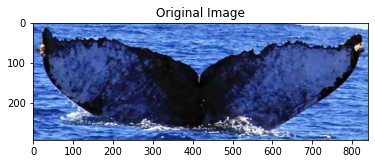

In [131]:

original_img = cv2.imread(f'datasets/train/train/bf64e8f6.jpg')
plt.title('Original Image')
plt.imshow(original_img[:, :, ::-1], )

In [114]:
import imgaug as ia
import imgaug.augmenters as iaa


### Rotate

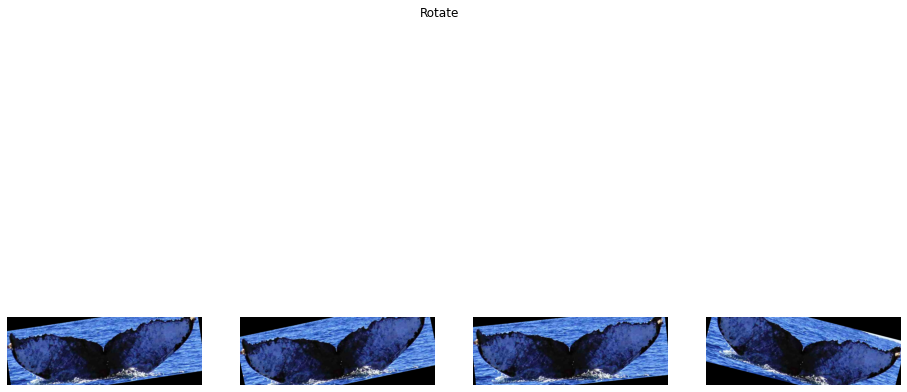

In [137]:
augmenter = iaa.Affine(rotate=(-15, 15))
imgs = augmenter.augment(images=[original_img]*4)

plot_images(imgs, title='Rotate')

### Shear

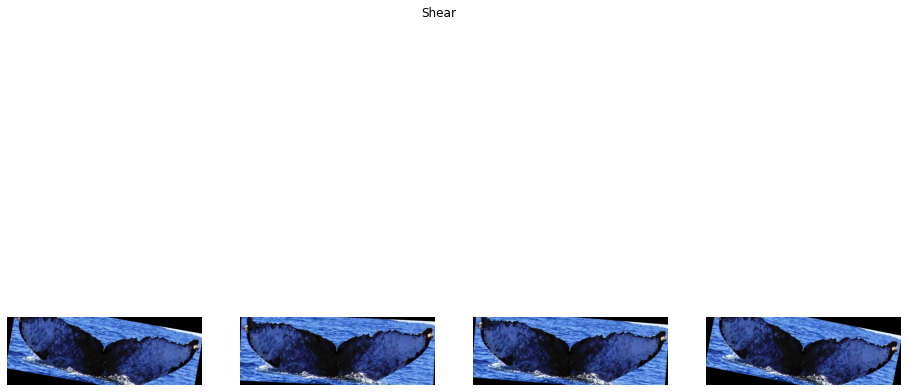

In [140]:
augmenter = iaa.Affine(shear=(-15, 15))
imgs = augmenter.augment(images=[original_img]*4)

plot_images(imgs, title='Shear')

### Random crop

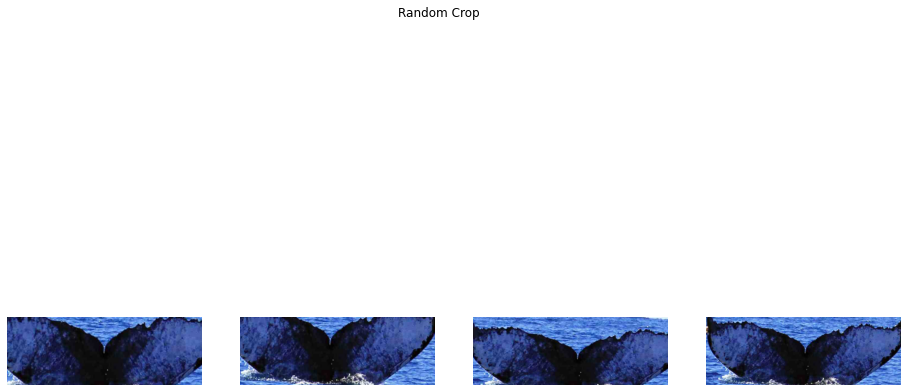

In [188]:
augmenter = iaa.Crop(percent=(0, 0.25))
imgs = augmenter.augment(images=[original_img]*4)

plot_images(imgs, title='Random Crop')

### Random gray scale

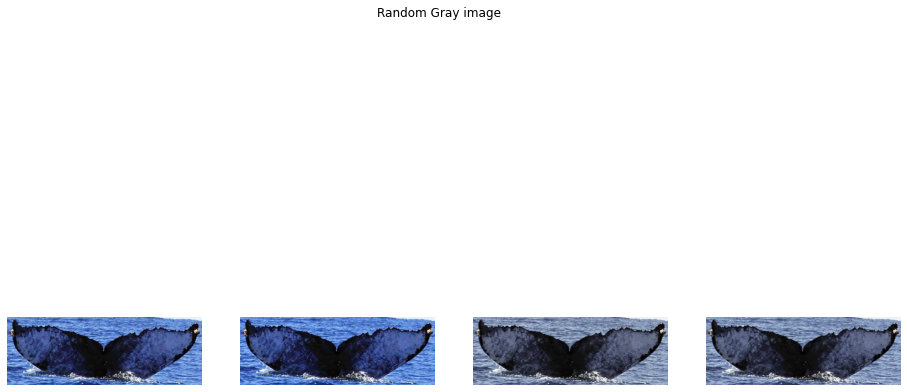

In [192]:
augmenter = iaa.Grayscale((0, 1))
imgs = augmenter.augment(images=[original_img]*4)

plot_images(imgs, title='Random Gray image')

### Combine all augmentation

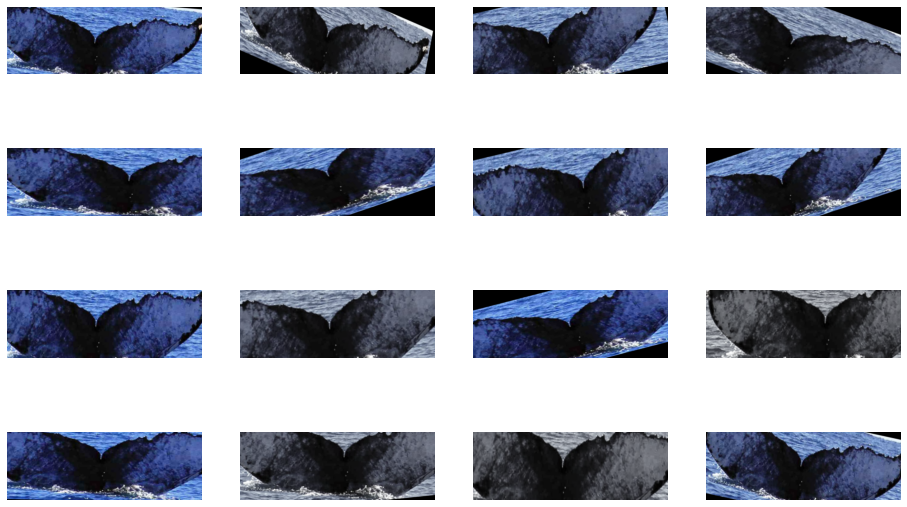

In [198]:

augment_pipeline = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),
    iaa.Affine(shear=(-15, 15)),
    iaa.Crop(percent=(0, 0.25)),
    iaa.Grayscale(alpha=(0, 1))
])
imgs = augment_pipeline.augment(images=[original_img]*16)
plot_images(imgs,)

## Train validation split for baseline model

From EDA, we saw this dataset is unbalance. We can't split data to train set and validation set with balanced whale ID if dataset contains a lot of small amount of image of any whale ID.

To fix this problem, we have to discard some of whale ID that have small amount of image (below 4). With this method, we will keep balance of whale ID on both set with validation ratio = 20% .

In [146]:
ID_MAPPER = {whale_id: i for i, whale_id in enumerate(df['Id'].sort_values().drop_duplicates().to_list())}
df['whale_id_index'] = df['Id'].apply(lambda whale_id: ID_MAPPER[whale_id])
df

,Image,Id,whale_id_index
1,000466c4.jpg,w_1287fbc,17
2,00087b01.jpg,w_da2efe0,269
7,0031c258.jpg,new_whale,0
8,0035632e.jpg,w_3d0bc7a,68
13,00467ae9.jpg,w_fd1cb9d,307
...,...,...,...
9836,ffa78ccc.jpg,w_89d9c03,161
9837,ffb71ac2.jpg,new_whale,0
9840,ffc0b437.jpg,w_ace8c54,208
9844,ffd1e7aa.jpg,new_whale,0


In [200]:
counts = df['Id'].value_counts()

non_single_id = counts[counts > 4].index
df = df[df['Id'].isin(non_single_id)]

Split with validation ratio = 0.2

In [201]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Id'], random_state=42)

In [203]:
print('Train set', len(train_df))

print('Val set', len(val_df))

Train set 2654
Val set 664


In [23]:
train_df.set_index('Image').to_csv('datasets/train_sets.csv')
val_df.set_index('Image').to_csv('datasets/val_sets.csv')